In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_style("whitegrid")


DAILY_DATA_PATH = "../data/dates_deaths.csv"


def import_clean_daily_data(daily_data_path: str) -> pd.DataFrame:
    """Cleans the datetimes in the dataset."""
    vefat_daily = pd.read_csv(daily_data_path, sep="\t", header=None)
    vefat_daily.columns = ["dates", "numbers"]
    vefat_daily = vefat_daily.loc[vefat_daily.numbers != "None", :]
    vefat_daily["numbers"] = pd.to_numeric(vefat_daily.numbers)
    vefat_daily["dates"] = pd.to_datetime(vefat_daily["dates"], dayfirst=True)
    vefat_daily.index = vefat_daily["dates"]
    del vefat_daily["dates"]
    return vefat_daily


def create_weekly_data(dataframe: pd.DataFrame, col_name: str, resample: bool = False) -> pd.DataFrame:
    """Takes the weekly average for a given dataframe and column name."""
    if resample:
        return dataframe[col_name].resample("W").mean()
    else:
        return dataframe[col_name].rolling(7, center=False).mean()


def plot_series(dataframe: pd.DataFrame, col_name: str = None, title: str = "") -> None:
    """To make it uniform in all the analysis."""
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.set_title(title)
    plt.ylabel("# of Deaths", fontsize=16)
    if col_name is not None:
        len_col = len(dataframe[col_name])
        series = dataframe[col_name]
    else:
        len_col = len(dataframe)
        series = deepcopy(dataframe)
    series.plot(linewidth=1.5, color="#FF6F26")
    plt.xlabel("", fontsize=18)
    plt.fill_between(series.index,
                     series.values,
                     0,
                     color="#FF6F26",
                     alpha=0.35)

In [2]:
daily_data = import_clean_daily_data(DAILY_DATA_PATH)
# Resampling will take the daily data into Weekly granularity
weekly_data = create_weekly_data(daily_data, "numbers", resample=True)

/home/nazli/anaconda3/envs/scraper/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [3]:
weekly_data

dates
2018-05-06    197.166667
2018-05-13    200.428571
2018-05-20    199.714286
2018-05-27    200.142857
2018-06-03    180.857143
                 ...    
2020-03-08    212.571429
2020-03-15    210.714286
2020-03-22    249.285714
2020-03-29    254.714286
2020-04-05    298.285714
Freq: W-SUN, Name: numbers, Length: 101, dtype: float64

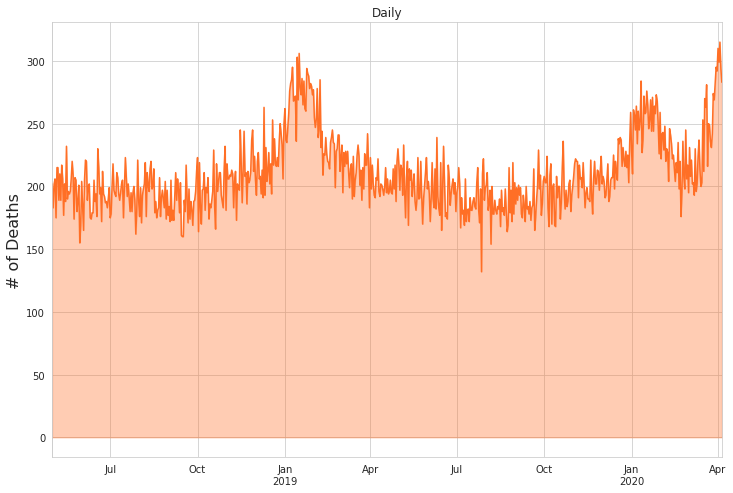

In [4]:
plot_series(dataframe=daily_data, col_name="numbers", title="Daily")

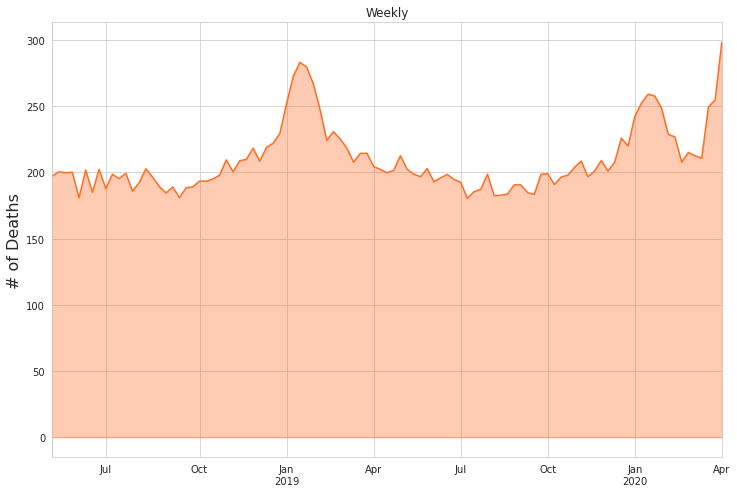

In [5]:
plot_series(dataframe=weekly_data, title="Weekly")

In [6]:
# Create training and testing
# Last 4 Weeks is going to be derived from 
train = weekly_data[:-5]
test = weekly_data[-5:]

In [7]:
model = auto_arima(train,
    start_p=1, start_q=1, 
    max_p=5, max_q=5,
    seasonal=True,
    d=1, max_d=7,
    trace=True, 
    error_action="ignore", 
    suppress_warnings=True, 
    stepwise=True)  
print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=705.979, BIC=716.194, Time=0.061 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=707.952, BIC=713.060, Time=0.007 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=709.318, BIC=716.980, Time=0.030 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=709.518, BIC=717.180, Time=0.042 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=705.987, BIC=708.540, Time=0.008 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=705.695, BIC=718.465, Time=0.078 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=705.751, BIC=715.966, Time=0.053 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=707.638, BIC=722.962, Time=0.127 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=707.631, BIC=722.954, Time=0.112 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=705.890, BIC=718.660, Time=0.086 seco

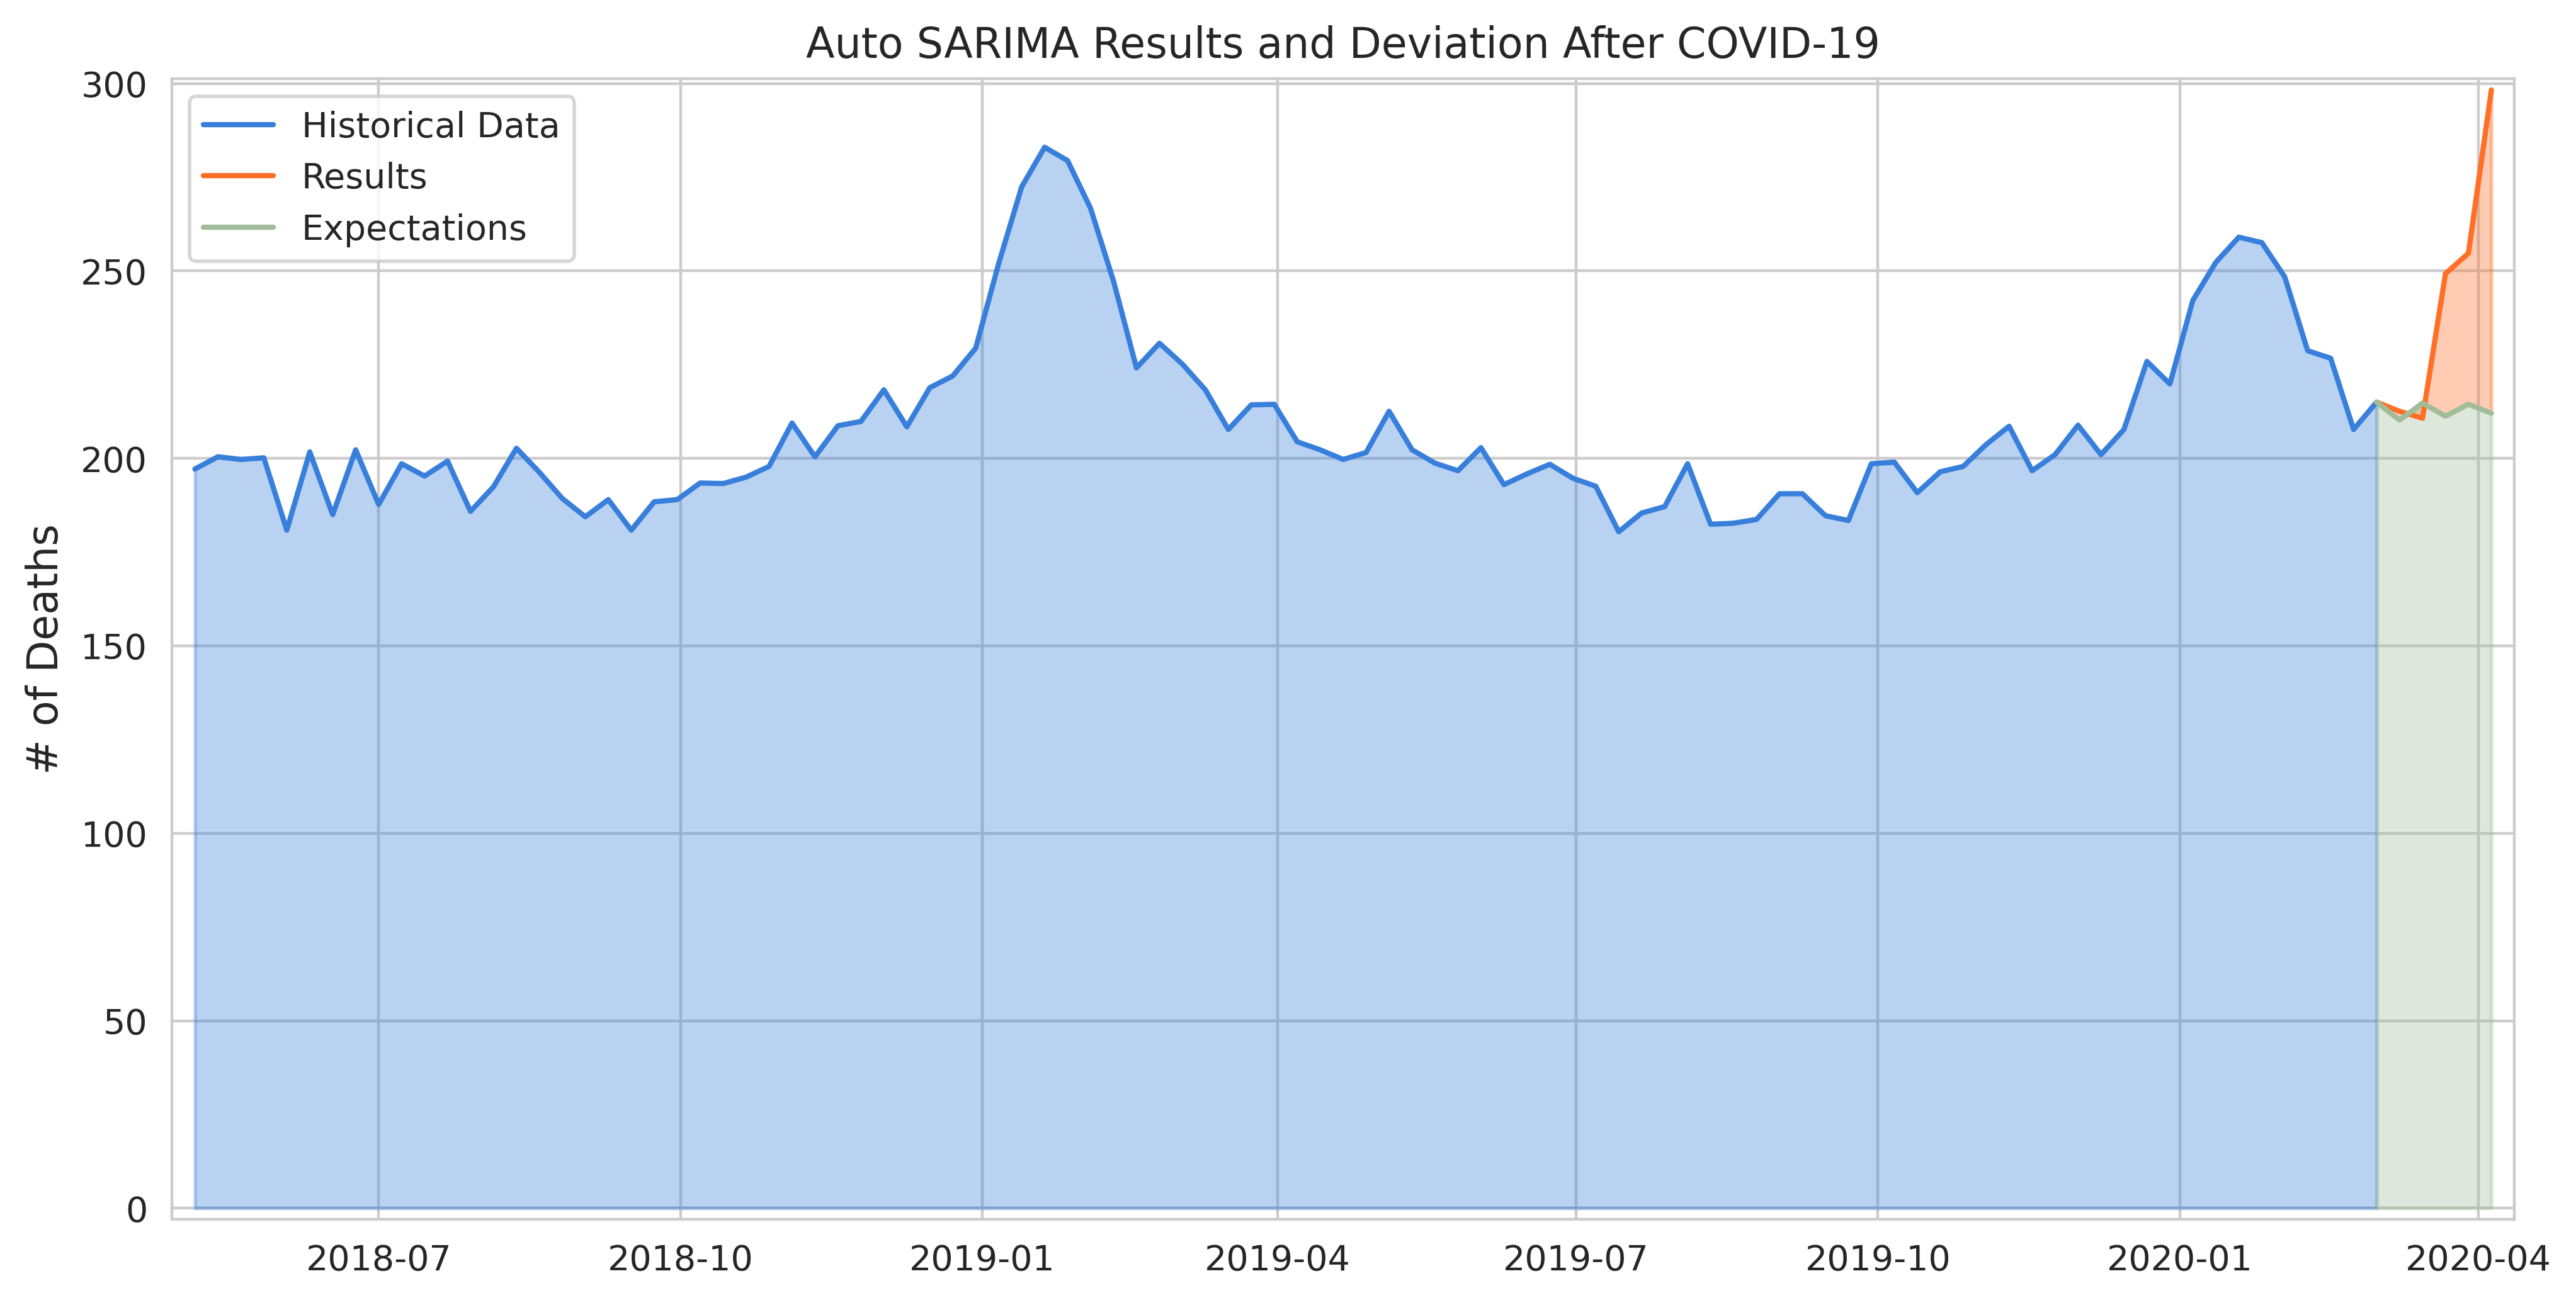

In [9]:
n_periods = 5

x_axis = list(weekly_data.index)

predicted = model.predict(n_periods=n_periods, return_conf_int=False)
index_of_fc = pd.date_range(train.index[-1], periods=n_periods+1, freq="W")

interpolated_predicted = np.append(train[-1], predicted)
interpolated_test = np.append(train[-1], test.values)

# make series for plotting purpose
fitted_series = pd.Series(interpolated_predicted, index=index_of_fc)
interpolated_test_series = pd.Series(interpolated_test, index=index_of_fc)

# Plot
plt.figure(figsize=(12, 6), dpi=400)
plt.tight_layout()
plt.margins(0.01)
history = plt.plot(train, color="#387FDC", label="Historical Data")
results = plt.plot(interpolated_test_series, color="#FF6F26", label="Results")
expectations = plt.plot(fitted_series, color="#A1BC99", label="Expectations")
plt.fill_between(interpolated_test_series.index,
                 interpolated_test_series.values,
                 fitted_series.values,
                 color="#FF6F26",
                 alpha=0.35)
plt.fill_between(train.index,
                 train.values,
                 0,
                 color="#387FDC",
                 alpha=0.35)
plt.fill_between(fitted_series.index,
                 fitted_series.values,
                 0,
                 color="#A1BC99",
                 alpha=0.35)
plt.ylabel("# of Deaths", fontsize=12)
plt.legend()
plt.title("Auto SARIMA Results and Deviation After COVID-19")
plt.savefig("deviation_ts_istanbul.png")